In [2]:
!pip install ace
!pip install seaborn

## Data Gen

### treatment decay mode

         X1        X2  time  T  Y    Y_prob
0  0.004967  0.010306     4  0  1  0.559768
1 -0.001383 -0.011554     1  0  0  0.555040
2  0.006477  0.005754     8  1  0  0.670521
3  0.015230 -0.006192     0  0  0  0.549655
4 -0.002342 -0.003274     0  1  1  0.732667


/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_3232/806243305.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='time', y='Y', hue='T', data=df_large, ci=None)


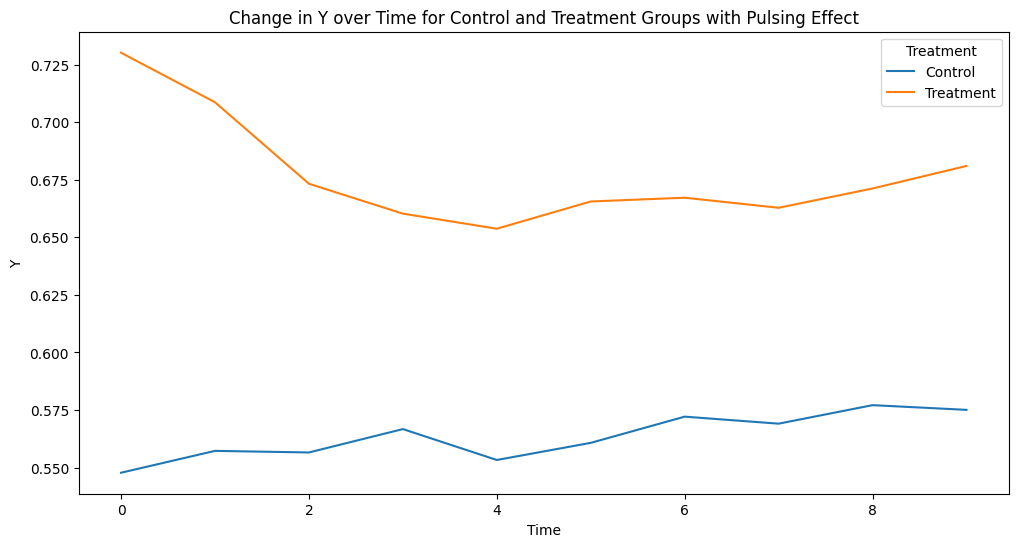

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

n = 100_000
X1 = np.random.normal(0, .01, n)
X2 = np.random.normal(0, .01, n)
T = np.random.binomial(1, p=1. / (1. + np.exp(-0.02 * X1 + 0.03 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = .8
decay_rate = 0.2
stabilization_time = 3.
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
continuous_Y = .2 + treatment_effect * T + 0.1 * X1 - 0.05 * X2 + 0.01 * time + np.random.normal(0, .01, n)
Y_prob = 1. / (1. + np.exp(-continuous_Y))
Y = np.random.binomial(1, Y_prob)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'time': time,
    'T': T,
    'Y': Y,
    'Y_prob': Y_prob,
})

# Display the first few rows of the dataset
print(df_large.head())

# Plot the dataset with the pulsing treatment effect
plt.figure(figsize=(12, 6))

# Plot the change in Y over time for control and treatment groups
sns.lineplot(x='time', y='Y', hue='T', data=df_large, ci=None)
plt.title('Change in Y over Time for Control and Treatment Groups with Pulsing Effect')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend(title='Treatment', labels=['Control', 'Treatment'])
plt.show()


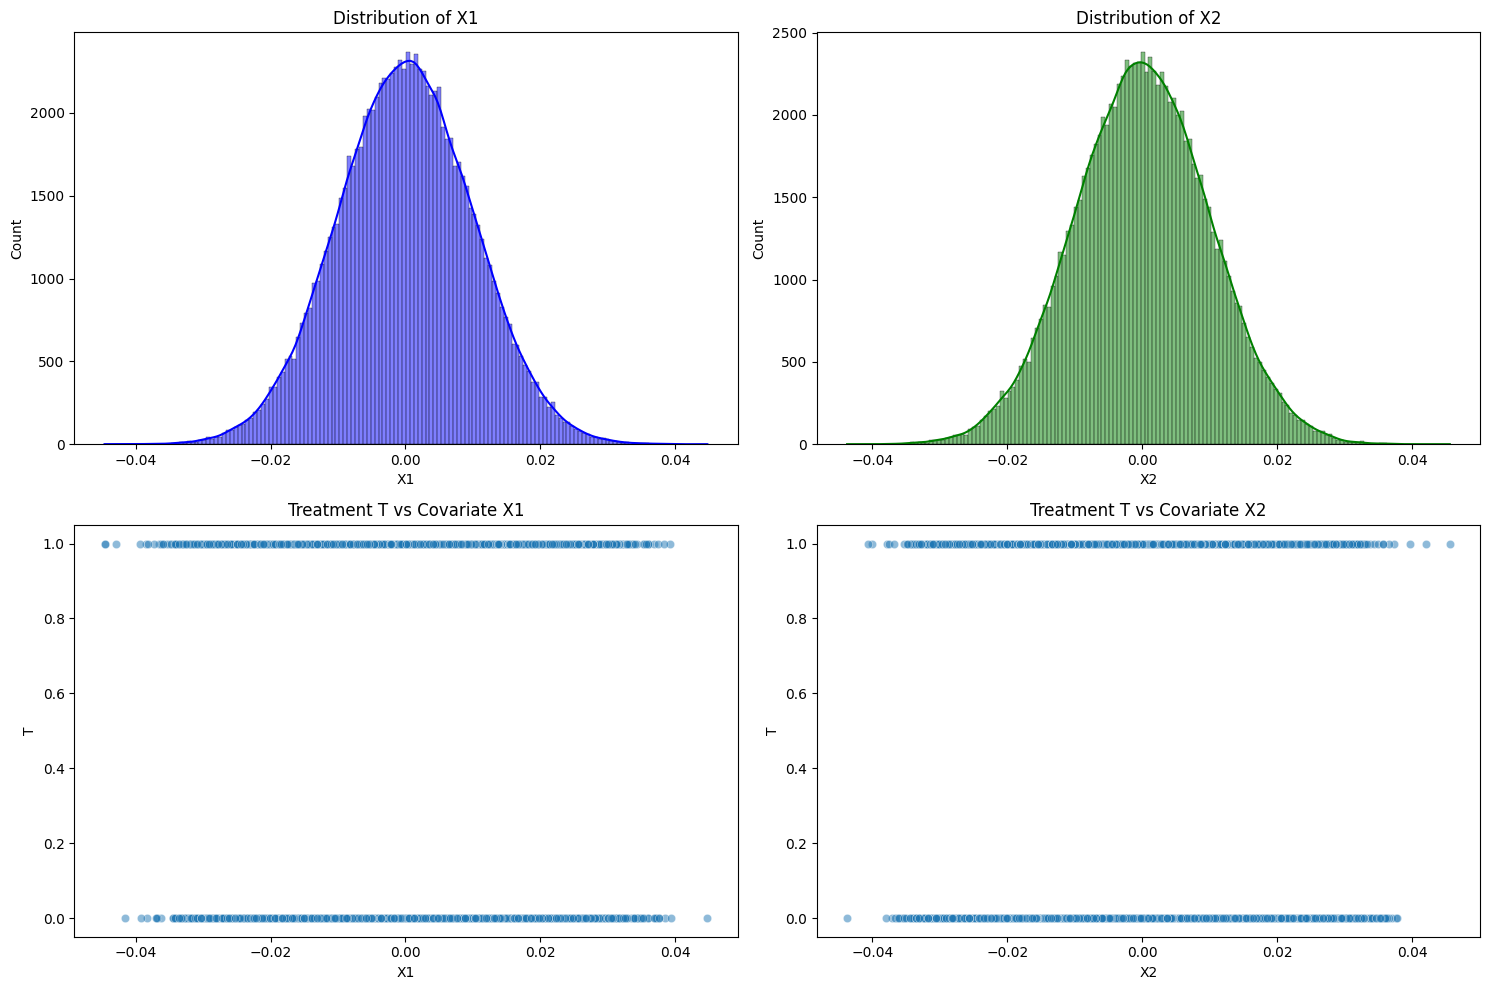

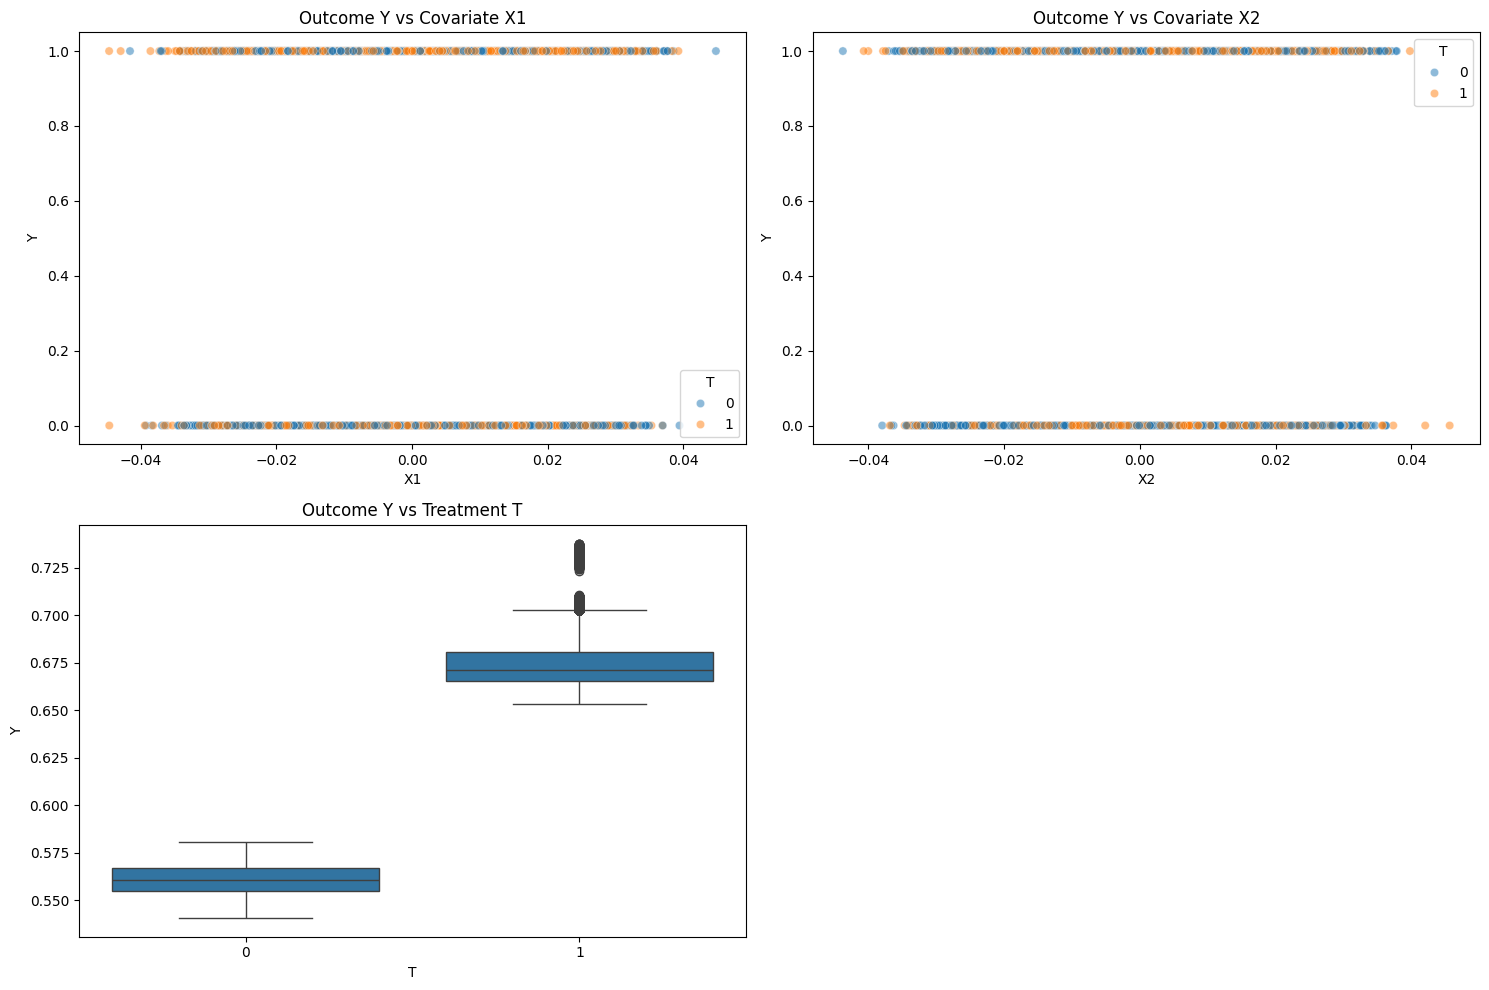

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))

# Plot the distribution of the covariates
plt.subplot(2, 2, 1)
sns.histplot(df_large['X1'], kde=True, color='blue')
plt.title('Distribution of X1')
plt.xlabel('X1')

plt.subplot(2, 2, 2)
sns.histplot(df_large['X2'], kde=True, color='green')
plt.title('Distribution of X2')
plt.xlabel('X2')

# Plot the relationship between the treatment variable and the covariates
plt.subplot(2, 2, 3)
sns.scatterplot(x='X1', y='T', data=df_large, alpha=0.5)
plt.title('Treatment T vs Covariate X1')
plt.xlabel('X1')
plt.ylabel('T')

plt.subplot(2, 2, 4)
sns.scatterplot(x='X2', y='T', data=df_large, alpha=0.5)
plt.title('Treatment T vs Covariate X2')
plt.xlabel('X2')
plt.ylabel('T')

plt.tight_layout()
plt.show()

# Set up another figure
plt.figure(figsize=(15, 10))

# Plot the relationship between the outcome variable and the covariates
plt.subplot(2, 2, 1)
sns.scatterplot(x='X1', y='Y', data=df_large, alpha=0.5, hue='T')
plt.title('Outcome Y vs Covariate X1')
plt.xlabel('X1')
plt.ylabel('Y')

plt.subplot(2, 2, 2)
sns.scatterplot(x='X2', y='Y', data=df_large, alpha=0.5, hue='T')
plt.title('Outcome Y vs Covariate X2')
plt.xlabel('X2')
plt.ylabel('Y')

# Plot the effect of the treatment variable on the outcome variable
plt.subplot(2, 2, 3)
sns.boxplot(x='T', y='Y_prob', data=df_large)
plt.title('Outcome Y vs Treatment T')
plt.xlabel('T')
plt.ylabel('Y')

plt.tight_layout()
plt.show()


### Hyper params

In [214]:
epochs = 20
batch_size = 500

In [215]:
X = df_large[['X1', 'X2', 'time', 'T']].values
T_input = df_large['T'].values.reshape(-1, 1)
y = df_large['Y'].values
y_prob = df_large['Y_prob'].values.reshape(-1, 1)
X_train, X_test, T_train, T_test, y_train, y_test, y_prob_train, y_prob_test = train_test_split(X, T_input, y, y_prob, test_size=0.2, random_state=42)

In [216]:
import numpy as np
import pandas as pd
import unittest

# AUUC Calculation Function
def calculate_auuc(y_true, uplift_score, treatment):
    sorted_indices = np.argsort(uplift_score)[::-1]
    y_sorted = y_true[sorted_indices]
    T_sorted = treatment[sorted_indices]
    cumulative_uplift = np.cumsum((T_sorted - (1 - T_sorted)) * y_sorted).astype(float)
    cumulative_uplift /= np.arange(1, len(cumulative_uplift) + 1)
    auuc = np.trapz(cumulative_uplift)
    return auuc

# Example test case for the calculate_auuc function
class TestAUUC(unittest.TestCase):
    def test_calculate_auuc(self):
        # Known values for a small test case
        y_true = np.array([0, 0, 1, 1])
        uplift_score = np.array([0.1, 0.4, 0.2, 0.3])
        treatment = np.array([1, 0, 1, 0])
        # Manually calculated cumulative uplift and AUUC
        # Sorted by uplift_score descending: indices [1, 3, 2, 0]
        y_sorted = np.array([2, 4, 3, 1])
        T_sorted = np.array([0, 0, 1, 1])
        cumulative_uplift = np.cumsum((T_sorted - (1 - T_sorted)) * y_sorted).astype(float)
        cumulative_uplift /= np.arange(1, len(cumulative_uplift) + 1)
        expected_auuc = np.trapz(cumulative_uplift)
        # Calculate AUUC using the function
        calculated_auuc = calculate_auuc(y_true, uplift_score, treatment)
        # Assert if the calculated AUUC matches the expected AUUC
        self.assertAlmostEqual(calculated_auuc, expected_auuc, places=5)
        
    def test_calculate_auuc_all_treatment(self):
        # Edge case where all samples are in the treatment group
        y_true = np.array([0, 0, 1, 1])
        uplift_score = np.array([0.1, 0.4, 0.2, 0.3])
        treatment = np.array([1, 1, 1, 1])
        # Calculate AUUC using the function
        calculated_auuc = calculate_auuc(y_true, uplift_score, treatment)
        # Expected AUUC should handle this edge case properly
        # Since all are treated, the uplift is simply the mean outcome
        expected_auuc = np.mean(y_true)
        # Assert if the calculated AUUC matches the expected AUUC
        self.assertAlmostEqual(calculated_auuc, expected_auuc, places=5)
        
    def test_calculate_auuc_all_control(self):
        # Edge case where all samples are in the control group
        y_true = np.array([0, 0, 1, 1])
        uplift_score = np.array([0.1, 0.4, 0.2, 0.3])
        treatment = np.array([0, 0, 0, 0])
        # Calculate AUUC using the function
        calculated_auuc = calculate_auuc(y_true, uplift_score, treatment)
        # Expected AUUC should handle this edge case properly
        # Since all are control, the uplift is zero
        expected_auuc = 0.0
        # Assert if the calculated AUUC matches the expected AUUC
        self.assertAlmostEqual(calculated_auuc, expected_auuc, places=5)


if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

FFF
FAIL: test_calculate_auuc (__main__.TestAUUC)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_3232/805582518.py", line 32, in test_calculate_auuc
    self.assertAlmostEqual(calculated_auuc, expected_auuc, places=5)
AssertionError: -0.5 != -5.25 within 5 places (4.75 difference)

FAIL: test_calculate_auuc_all_control (__main__.TestAUUC)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/var/folders/ls/5qzq87350jz6pv6jwnpg6mkm0000gn/T/ipykernel_3232/805582518.py", line 58, in test_calculate_auuc_all_control
    self.assertAlmostEqual(calculated_auuc, expected_auuc, places=5)
AssertionError: -1.4166666666666665 != 0.0 within 5 places (1.4166666666666665 difference)

FAIL: test_calculate_auuc_all_treatment (__main__.TestAUUC)
----------------------------------------------------------------------
Trac

## NN fit it directly

Epoch 1/20


2024-06-01 20:21:48.970436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.6591

2024-06-01 20:21:50.311491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 2s 8ms/step - loss: 0.6591 - val_loss: 0.6584
Epoch 2/20
128/128 [==============================] - 0s 4ms/step - loss: 0.6580 - val_loss: 0.6580
Epoch 3/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6576 - val_loss: 0.6596
Epoch 4/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6576 - val_loss: 0.6588
Epoch 5/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6576 - val_loss: 0.6579
Epoch 6/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6574 - val_loss: 0.6583
Epoch 7/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6574 - val_loss: 0.6592
Epoch 8/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6573 - val_loss: 0.6591
Epoch 9/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6573 - val_loss: 0.6581
Epoch 10/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6572 - val_loss: 0.6582
Epoch 11/2

2024-06-01 20:22:01.201633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.6530903577804565
 74/625 [==>...........................] - ETA: 0s

2024-06-01 20:22:02.935384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 1s 2ms/step
Calibrated threshold: 0.618575


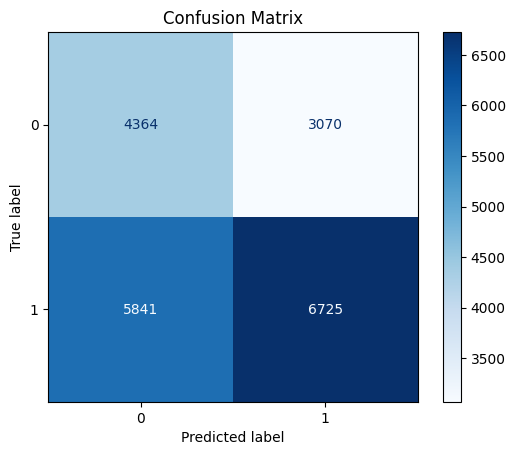

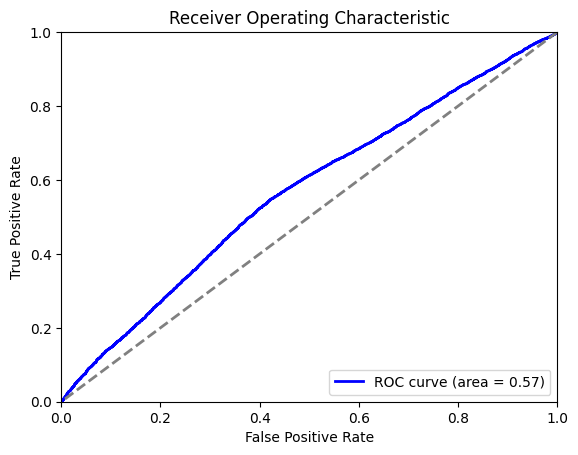

AUUC on Test Data: 1582.6447153404183


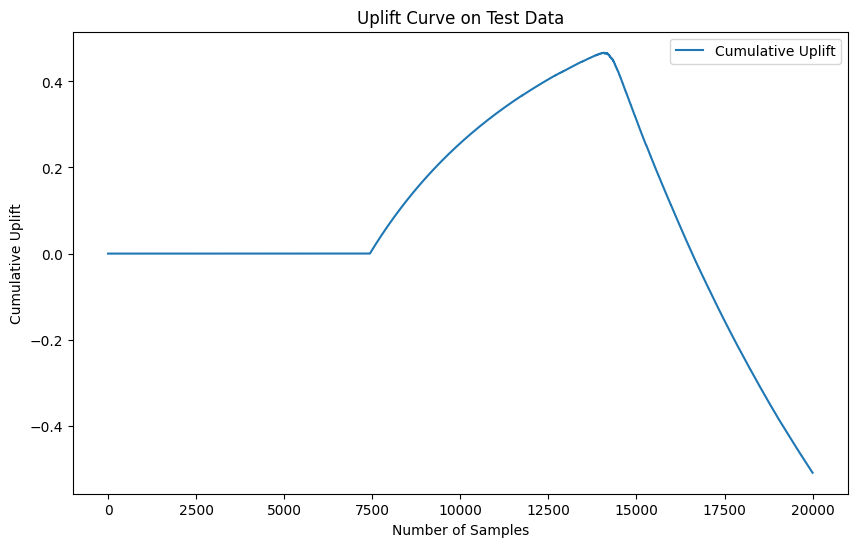

In [217]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt


X = df_large[['X1', 'X2', 'time', 'T']].values
T_input = df_large['T'].values.reshape(-1, 1)
y = df_large['Y'].values
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T_input, y, test_size=0.2, random_state=42)
threshold = np.mean(y_train)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions on the test data
y_pred_prob = model.predict(X_test)

# Calibrate the threshold using the average of y in the training set
threshold = np.mean(y_train)
print(f'Calibrated threshold: {threshold}')

# Convert probabilities to binary outcomes using the calibrated threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([1, 0], [1, 0], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Calculate the uplift score on the original data
uplift_score_full = y_pred_prob.flatten() - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score_full)[::-1]
y_sorted = y_test[sorted_indices]
T_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift_full = np.cumsum((T_sorted - (1 - T_sorted)) * y_sorted).astype(float)
cumulative_uplift_full /= np.arange(1, len(cumulative_uplift_full) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift_full, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve on Test Data')
plt.legend()

# Calculate AUUC
auuc_full = np.trapz(cumulative_uplift_full)
print(f'AUUC on Test Data: {auuc_full}')

plt.show()


Epoch 1/20


2024-06-01 20:22:04.798220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/128 [===========================>..] - ETA: 0s - loss: 0.6625

2024-06-01 20:22:06.295111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 2s 10ms/step - loss: 0.6625 - val_loss: 0.6584
Epoch 2/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6579 - val_loss: 0.6582
Epoch 3/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6576 - val_loss: 0.6598
Epoch 4/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6576 - val_loss: 0.6584
Epoch 5/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6575 - val_loss: 0.6577
Epoch 6/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6574 - val_loss: 0.6583
Epoch 7/20
128/128 [==============================] - 1s 4ms/step - loss: 0.6575 - val_loss: 0.6592
Epoch 8/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6575 - val_loss: 0.6585
Epoch 9/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6574 - val_loss: 0.6579
Epoch 10/20
128/128 [==============================] - 1s 5ms/step - loss: 0.6574 - val_loss: 0.6580
Epoch 11/

2024-06-01 20:22:18.746002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.653099775314331
 26/625 [>.............................] - ETA: 1s  

2024-06-01 20:22:20.587065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 1s 2ms/step
Calibrated threshold: 0.618575


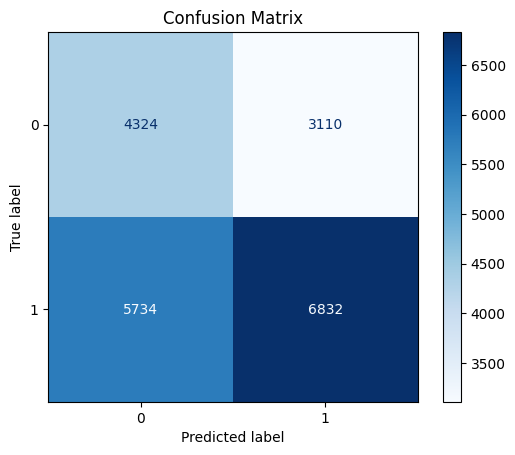

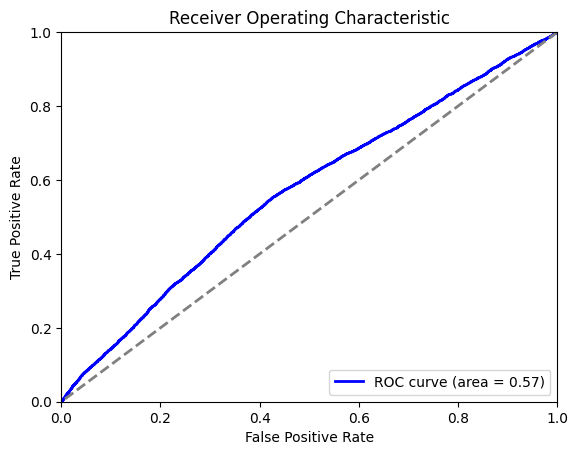

AUUC on Test Data: 1601.155915472232


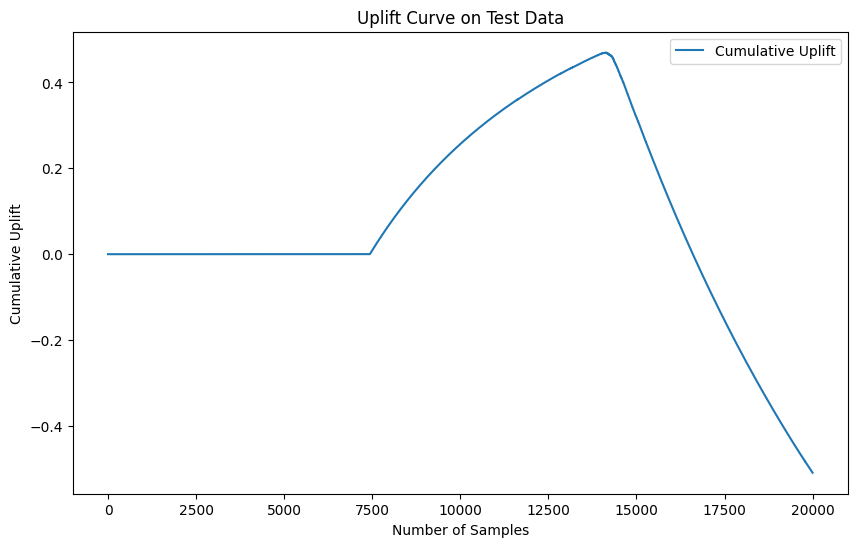

In [218]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# T as input and concat
X = df_large[['X1', 'X2', 'time', 'T']].values
T_input = df_large['T'].values.reshape(-1, 1)
y = df_large['Y'].values
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T_input, y, test_size=0.2, random_state=42)
threshold = np.mean(y_train)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the neural network model with custom layers
input_features = Input(shape=(X_train.shape[1],))
treatment_input = Input(shape=(1,))
x = Dense(128, activation='relu')(input_features)
x = Dense(128, activation='relu')(x)
x = Dense(16)(x)
y_hat = Lambda(lambda x: tf.exp(x))(x)
concatenated = Concatenate()([y_hat, treatment_input])
output = Dense(16, activation='relu')(concatenated)
output = Dense(16, activation='relu')(output)
output = Dense(1, activation='sigmoid')(output)
model = Model(inputs=[input_features, treatment_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = model.fit([X_train, T_train], y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

# Evaluate the model
loss = model.evaluate([X_test, T_test], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions on the test data
y_pred_prob = model.predict([X_test, T_test])

# Calibrate the threshold using the average of y in the training set
threshold = np.mean(y_train)
print(f'Calibrated threshold: {threshold}')

# Convert probabilities to binary outcomes using the calibrated threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([1, 0], [1, 0], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Calculate the uplift score on the original data
uplift_score_full = y_pred_prob.flatten() - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score_full)[::-1]
y_sorted = y_test[sorted_indices]
T_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift_full = np.cumsum((T_sorted - (1 - T_sorted)) * y_sorted).astype(float)
cumulative_uplift_full /= np.arange(1, len(cumulative_uplift_full) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift_full, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve on Test Data')
plt.legend()

# Calculate AUUC
auuc_full = np.trapz(cumulative_uplift_full)
print(f'AUUC on Test Data: {auuc_full}')

plt.show()


Epoch 1/20


2024-06-01 20:22:22.467646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


125/128 [============================>.] - ETA: 0s - loss: 0.6713

2024-06-01 20:22:25.724943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 4s 19ms/step - loss: 0.6713 - val_loss: 0.6590
Epoch 2/20
128/128 [==============================] - 1s 12ms/step - loss: 0.6621 - val_loss: 0.6587
Epoch 3/20
128/128 [==============================] - 2s 12ms/step - loss: 0.6608 - val_loss: 0.6598
Epoch 4/20
128/128 [==============================] - 1s 11ms/step - loss: 0.6599 - val_loss: 0.6590
Epoch 5/20
128/128 [==============================] - 2s 12ms/step - loss: 0.6596 - val_loss: 0.6584
Epoch 6/20
128/128 [==============================] - 2s 13ms/step - loss: 0.6596 - val_loss: 0.6585
Epoch 7/20
128/128 [==============================] - 2s 12ms/step - loss: 0.6595 - val_loss: 0.6593
Epoch 8/20
128/128 [==============================] - 1s 11ms/step - loss: 0.6596 - val_loss: 0.6595
Epoch 9/20
128/128 [==============================] - 2s 12ms/step - loss: 0.6592 - val_loss: 0.6581
Epoch 10/20
128/128 [==============================] - 2s 12ms/step - loss: 0.6593 - val_loss: 0.6583


2024-06-01 20:22:46.307989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 0.6528463363647461


2024-06-01 20:22:52.230858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 4s 5ms/step
Calibrated threshold: 0.618575


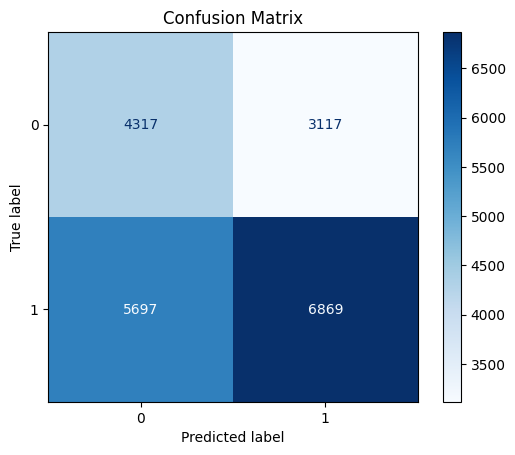

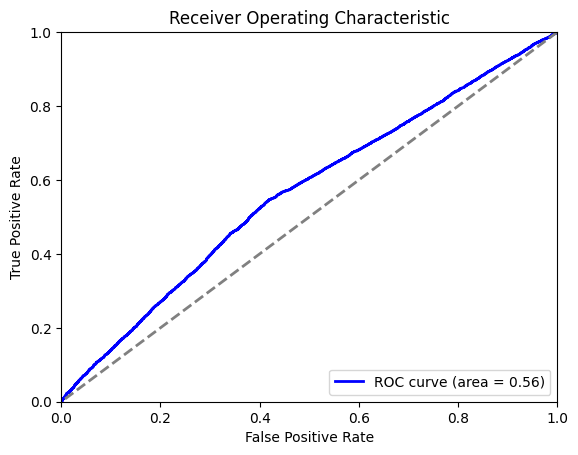

AUUC on Test Data: 1615.2369653197186


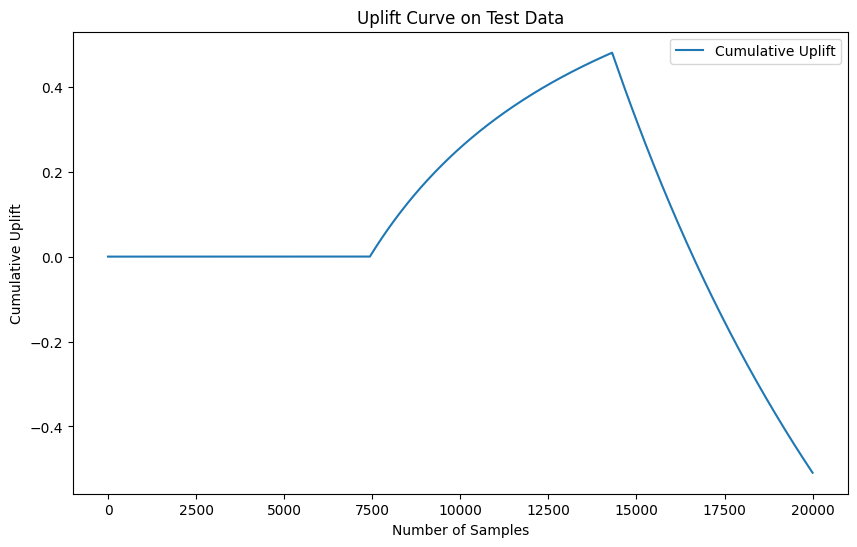

In [219]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X = df_large[['X1', 'X2', 'time', 'T']].values
T_input = df_large['T'].values.reshape(-1, 1)
y = df_large['Y'].values
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T_input, y, test_size=0.2, random_state=42)
threshold = np.mean(y_train)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define Transformer block
def transformer_block(inputs, num_heads, ff_dim, dropout=0.2):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

# Define the neural network model
input0 = Input(shape=(1,), name='time')
input1 = Input(shape=(1,), name='treatment')
input2 = Input(shape=(2,), name='features')

# Concatenate inputs for the transformer block
concat_inputs = Concatenate()([input0, input1, input2, input2, input1, input0])
concat_inputs = tf.expand_dims(concat_inputs, axis=1)

# Apply transformer block
transformer_output = transformer_block(concat_inputs, num_heads=2, ff_dim=32)
transformer_output = tf.squeeze(transformer_output, axis=1)

# Output layer
output = Dense(1, activation='sigmoid')(transformer_output)

# Create the model
model = Model(inputs=[input0, input1, input2], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model
history = model.fit(
    [X_train[:, 2], X_train[:, 3], X_train[:, 0:2]], 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model
loss = model.evaluate([X_test[:, 2], X_test[:, 3], X_test[:, 0:2]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions on the test data
y_pred_prob = model.predict([X_test[:, 2], X_test[:, 3], X_test[:, 0:2]])

# Calibrate the threshold using the average of y in the training set
threshold = np.mean(y_train)
print(f'Calibrated threshold: {threshold}')

# Convert probabilities to binary outcomes using the calibrated threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([1, 0], [1, 0], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Calculate the uplift score on the original data
uplift_score_full = y_pred_prob.flatten() - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score_full)[::-1]
y_sorted = y_test[sorted_indices]
T_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift_full = np.cumsum((T_sorted - (1 - T_sorted)) * y_sorted).astype(float)
cumulative_uplift_full /= np.arange(1, len(cumulative_uplift_full) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift_full, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve on Test Data')
plt.legend()

# Calculate AUUC
auuc_full = np.trapz(cumulative_uplift_full)
print(f'AUUC on Test Data: {auuc_full}')

plt.show()

In [231]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda, Reshape, Flatten, Embedding, PositionalEncoding, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X = df_large[['X1', 'X2', 'time', 'T']].values
T_input = df_large['T'].values.reshape(-1, 1)
y = df_large['Y'].values
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T_input, y, test_size=0.2, random_state=42)
threshold = np.mean(y_train)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim)]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_encoder_decoder_model():
    input0 = Input(shape=(1,), name='time_input')
    input1 = Input(shape=(1,), name='T_input')
    input2 = Input(shape=(1, 2), name='features_input')

    # Duplicate the time and T inputs to match the width of X1_X2
    duplicated0 = Lambda(lambda x: tf.tile(x, [1, 2]))(input0)
    duplicated1 = Lambda(lambda x: tf.tile(x, [1, 2]))(input1)

    # Reshape duplicated inputs to match the 3D shape needed for concatenation
    duplicated0 = Reshape((2, 1))(duplicated0)
    duplicated1 = Reshape((2, 1))(duplicated1)
    input2 = Reshape((2, 1))(input2)
    # Concatenate inputs for the encoder
    encoder_inputs = Concatenate(axis=-1)([duplicated0, duplicated1, input2, input2, duplicated1, duplicated0])
    # Encoder
    num_transformer_blocks = 2
    embed_dim = 6
    num_heads = 2
    ff_dim = 2
    x = encoder_inputs
    for _ in range(num_transformer_blocks):
        x = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim)(x)
    encoder_outputs = x
    # Decoder
    decoder_inputs = encoder_outputs
    for _ in range(num_transformer_blocks):
        decoder_inputs = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim)(decoder_inputs)

    # Flatten the output and add the final Dense layer
    decoder_outputs = Flatten()(decoder_inputs)
    decoder_outputs = Dense(10, activation='relu')(decoder_outputs)
    output = Dense(1, activation='sigmoid')(decoder_outputs)

    # Define and compile the model
    model = Model(inputs=[input0, input1, input2], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model


# def build_encoder_decoder_model():
#     # Define the inputs
#     input_time = Input(shape=(1,), name='time_input')
#     input_T = Input(shape=(1,), name='T_input')
#     input_X1_X2 = Input(shape=(1, 2), name='X1_X2_input')

#     # Duplicate the time and T inputs to match the width of X1_X2
#     duplicated_time = Lambda(lambda x: tf.tile(x, [1, 2]))(input_time)
#     duplicated_T = Lambda(lambda x: tf.tile(x, [1, 2]))(input_T)

#     # Reshape duplicated inputs to match the 3D shape needed for concatenation
#     duplicated_time = Reshape((2, 1))(duplicated_time)
#     duplicated_T = Reshape((2, 1))(duplicated_T)
#     input_X1_X2 = Reshape((2, 1))(input_X1_X2)

#     # Concatenate inputs for the encoder
#     encoder_inputs = Concatenate(axis=-1)([duplicated_time, duplicated_T, input_X1_X2])

#     # Ensure consistent embedding dimension
#     embed_dim = 3  # Set the embedding dimension for inputs
#     encoder_inputs = Dense(embed_dim)(encoder_inputs)  # Project inputs to embed_dim

#     # Encoder
#     num_transformer_blocks = 1
#     num_heads = 2
#     ff_dim = 4

#     x = encoder_inputs
#     for _ in range(num_transformer_blocks):
#         x = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim)(x)
#     encoder_outputs = x

#     # Decoder
#     decoder_inputs = encoder_outputs
#     for _ in range(num_transformer_blocks):
#         decoder_inputs = TransformerBlock(embed_dim=embed_dim, num_heads=num_heads, ff_dim=ff_dim)(decoder_inputs)
#     decoder_outputs = decoder_inputs

#     # Flatten the output and add the final Dense layer
#     decoder_outputs = Dense(embed_dim)(decoder_outputs)
#     output = Dense(1, activation='sigmoid')(decoder_outputs)

#     # Define and compile the model
#     model = Model(inputs=[input_time, input_T, input_X1_X2], outputs=output)
#     model.compile(optimizer='adam', loss='binary_crossentropy')

#     return model

def create_model(seq_length=1, num_conditional_features=4, d_model=2, num_heads=2, ff_dim=4, num_layers=4):
    # Inputs
    conditional_input = Input(shape=(num_conditional_features,), name='conditional_input')
    treatment_input = Input(shape=(seq_length,), name='treatment_input')
    
    # Embedding and Positional Encoding for the treatment sequence
    treatment_embedding = Embedding(input_dim=10000, output_dim=d_model)(treatment_input)  # Adjust input_dim as necessary
    treatment_pos_encoding = PositionalEncoding(d_model)(treatment_embedding)

    # Transformer Encoder
    transformer_output = treatment_pos_encoding
    for _ in range(num_layers):
        transformer_output = transformer_block(transformer_output, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=0.1)
    
    # Global Average Pooling
    transformer_output = GlobalAveragePooling1D()(transformer_output)
    
    # Concatenate the transformer output with the conditional features
    concatenated = Concatenate()([transformer_output, conditional_input])
    
    # Output layer
    output = Dense(1, activation='sigmoid')(concatenated)
    
    # Model
    model = Model(inputs=[conditional_input, treatment_input], outputs=output)
    return model

# Create the model
model = build_encoder_decoder_model()

# Train the model with gradient clipping
history = model.fit(
    [X_train[:, 4], X_train[:, 0:4]], 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model
loss = model.evaluate([X_test[:, 2], X_test[:, 3], X_test[:, 0:2]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions on the test data
y_pred_prob = model.predict([X_test[:, 2], X_test[:, 3], X_test[:, 0:2]])

# Calibrate the threshold using the average of y in the training set
threshold = np.mean(y_train)
print(f'Calibrated threshold: {threshold}')

# Convert probabilities to binary outcomes using the calibrated threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([1, 0], [1, 0], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Calculate the uplift score on the original data
uplift_score_full = y_pred_prob.flatten() - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score_full)[::-1]
y_sorted = y_test[sorted_indices]
T_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift_full = np.cumsum((T_sorted - (1 - T_sorted)) * y_sorted).astype(float)
cumulative_uplift_full /= np.arange(1, len(cumulative_uplift_full) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift_full, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve on Test Data')
plt.legend()

# Calculate AUUC
auuc_full = np.trapz(cumulative_uplift_full)
print(f'AUUC on Test Data: {auuc_full}')

plt.show()

Epoch 1/20


2024-06-01 20:44:19.955974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 2.1218

2024-06-01 20:44:38.180123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 25s 1s/step - loss: 2.1218 - val_loss: 1.2417
Epoch 2/20
13/13 [==============================] - 1s 107ms/step - loss: 0.9063 - val_loss: 0.3165
Epoch 3/20
13/13 [==============================] - 1s 92ms/step - loss: 0.1476 - val_loss: -0.3621
Epoch 4/20
13/13 [==============================] - 1s 79ms/step - loss: -0.5999 - val_loss: -1.2955
Epoch 5/20
13/13 [==============================] - 1s 69ms/step - loss: -1.5481 - val_loss: -2.3361
Epoch 6/20
13/13 [==============================] - 1s 64ms/step - loss: -2.5632 - val_loss: -3.4712
Epoch 7/20
 5/13 [==========>...................] - ETA: 0s - loss: -3.3878

KeyboardInterrupt: 

In [254]:


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, LayerNormalization, Dropout, MultiHeadAttention, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import numpy as np


import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda, Reshape, Flatten, Embedding, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


X = df_large[['X1', 'X2', 'time', 'T']].values
T_input = df_large['T'].values.reshape(-1, 1)
y = df_large['Y'].values
X_train, X_test, T_train, T_test, y_train, y_test = train_test_split(X, T_input, y, test_size=0.2, random_state=42)
threshold = np.mean(y_train)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(max_len, d_model)

    def positional_encoding(self, max_len, d_model):
        angle_rads = self.get_angles(np.arange(max_len)[:, np.newaxis], np.arange(d_model)[np.newaxis, :], d_model)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, d_model):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        return pos * angle_rates

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

def transformer_block(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Network
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation='relu')(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def create_model(num_conditional_features, num_treatment_labels, d_model, num_heads, ff_dim, num_layers):
    
    time_input = Input(shape=(1,), name='time_input')
    treatment_input = Input(shape=(1,), name='treatment_input')
    feature_input = Input(shape=(num_conditional_features,), name='feature_input')
    
    # Reshape inputs to match expected dimensions
    time_input_reshaped = Reshape((1, 1))(time_input)
    treatment_input_reshaped = Reshape((1, 1))(treatment_input)
    feature_input_reshaped = Reshape((1, num_conditional_features))(feature_input)
    
    # Embedding and Positional Encoding for the time input
    time_embedding = Dense(d_model)(time_input_reshaped)
    time_pos_encoding = PositionalEncoding(d_model)(time_embedding)
    
    # Embedding and Positional Encoding for the treatment labels
    treatment_embedding = Embedding(input_dim=num_treatment_labels, output_dim=d_model)(treatment_input_reshaped)
    treatment_pos_encoding = PositionalEncoding(d_model)(treatment_embedding)
    
    # Embedding for features (Assuming they are already numerical, we just project to the same dimension)
    feature_embedding = Dense(d_model)(feature_input_reshaped)
    
    # Concatenate all inputs along the sequence dimension
    concatenated_inputs = Concatenate(axis=1)([time_pos_encoding, treatment_pos_encoding, feature_embedding])
    
    # Transformer Encoder
    transformer_output = concatenated_inputs
    for _ in range(num_layers):
        transformer_output = transformer_block(transformer_output, head_size=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=0.1)
    
    # Global Average Pooling
    transformer_output = GlobalAveragePooling1D()(transformer_output)
    
    # Output layer
    output = Dense(1, activation='sigmoid')(transformer_output)
    
    # Model
    model = Model(inputs=[time_input, treatment_input, feature_input], outputs=output)
    return model

# Parameters
num_conditional_features = 4
num_treatment_labels = 2
d_model = 4
num_heads = 2
ff_dim = 256
num_layers = 1

# Create model
model = create_model(num_conditional_features, num_treatment_labels, d_model, num_heads, ff_dim, num_layers)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

# Create the model
model = build_encoder_decoder_model()

# Train the model with gradient clipping
history = model.fit(
    [X_train[:, 2], X_train[:, 3], X_train[:, 0:4]], 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Evaluate the model
loss = model.evaluate([X_test[:, 2], X_test[:, 3], X_test[:, 0:4]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions on the test data
y_pred_prob = model.predict([X_test[:, 2], X_test[:, 3], X_test[:, 0:4]])

# Calibrate the threshold using the average of y in the training set
threshold = np.mean(y_train)
print(f'Calibrated threshold: {threshold}')

# Convert probabilities to binary outcomes using the calibrated threshold
y_pred = (y_pred_prob > threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([1, 0], [1, 0], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Calculate the uplift score on the original data
uplift_score_full = y_pred_prob.flatten() - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score_full)[::-1]
y_sorted = y_test[sorted_indices]
T_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift_full = np.cumsum((T_sorted - (1 - T_sorted)) * y_sorted).astype(float)
cumulative_uplift_full /= np.arange(1, len(cumulative_uplift_full) + 1)

# Plot the uplift curve
plt.figure(figsize=(10, 6))
plt.plot(cumulative_uplift_full, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve on Test Data')
plt.legend()

# Calculate AUUC
auuc_full = np.trapz(cumulative_uplift_full)
print(f'AUUC on Test Data: {auuc_full}')

plt.show()


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 1, 4), (None, 1, 1, 4), (None, 1, 4)]

## All in one

Number of NaNs in the dataset: 0
Epoch 1/10


2024-06-01 20:24:39.908919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 716124.7500

2024-06-01 20:24:42.969296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 4s 192ms/step - loss: 716124.7500 - val_loss: 665573.8750
Epoch 2/10
13/13 [==============================] - 0s 23ms/step - loss: 657945.5000 - val_loss: 609937.3750
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 602331.2500 - val_loss: 558021.2500
Epoch 4/10
13/13 [==============================] - 0s 18ms/step - loss: 550625.3750 - val_loss: 509474.5625
Epoch 5/10
13/13 [==============================] - 0s 20ms/step - loss: 502306.1562 - val_loss: 464216.1250
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 457128.5625 - val_loss: 422561.2500
Epoch 7/10
13/13 [==============================] - 0s 29ms/step - loss: 415495.1562 - val_loss: 383748.3125
Epoch 8/10
13/13 [==============================] - 0s 18ms/step - loss: 377185.1250 - val_loss: 347524.9062
Epoch 9/10
13/13 [==============================] - 0s 20ms/step - loss: 341100.6875 - val_loss: 314412.1562
Epoch 10/10
13/13 [==========

2024-06-01 20:24:46.311958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 35ms/step - loss: 7.0119 - val_loss: 4.3381
Epoch 2/10
 1/13 [=>............................] - ETA: 0s - loss: 4.0290

2024-06-01 20:24:46.964141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 5ms/step - loss: 3.4236 - val_loss: 3.0012
Epoch 3/10
13/13 [==============================] - 0s 5ms/step - loss: 2.8261 - val_loss: 2.7123
Epoch 4/10
13/13 [==============================] - 0s 5ms/step - loss: 2.4626 - val_loss: 2.2764
Epoch 5/10
13/13 [==============================] - 0s 5ms/step - loss: 2.0746 - val_loss: 1.9242
Epoch 6/10
13/13 [==============================] - 0s 5ms/step - loss: 1.7768 - val_loss: 1.6548
Epoch 7/10
13/13 [==============================] - 0s 5ms/step - loss: 1.5500 - val_loss: 1.4624
Epoch 8/10
13/13 [==============================] - 0s 5ms/step - loss: 1.4044 - val_loss: 1.3439
Epoch 9/10
13/13 [==============================] - 0s 4ms/step - loss: 1.3213 - val_loss: 1.2751
Epoch 10/10
13/13 [==============================] - 0s 4ms/step - loss: 1.2704 - val_loss: 1.2265
Transformer Test loss: 294394.34375
NN Test loss: 1.2817025184631348


2024-06-01 20:24:49.116943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 0s 2ms/step


2024-06-01 20:24:50.918519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


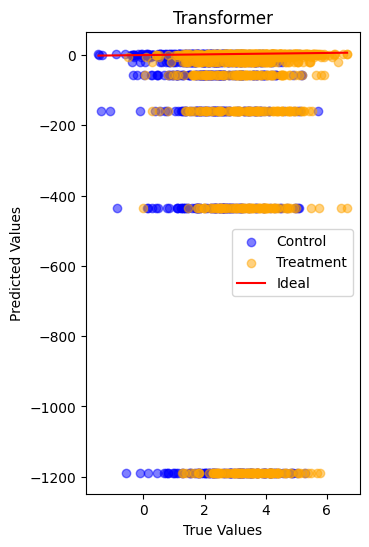

In [221]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import spektral
from spektral.layers import GCNConv

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate the dataset as previously described
n = 10000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Check for NaNs in the data
print("Number of NaNs in the dataset:", df_large.isnull().sum().sum())

# Prepare the data for training
X = df_large[['time', 'X1', 'X2', 'T']].values
y = df_large['Y'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train[:, 1:3] = scaler.fit_transform(X_train[:, 1:3])
X_test[:, 1:3] = scaler.transform(X_test[:, 1:3])

# Transformer Model
def transformer_model():
    input0 = Input(shape=(1,), name='time')
    input1 = Input(shape=(1,), name='treatment')
    input2 = Input(shape=(2,), name='features')

    concat_inputs = Concatenate()([input0, input1, input2])
    concat_inputs = tf.expand_dims(concat_inputs, axis=1)

    def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
        attn_output = Dropout(dropout)(attn_output)
        out1 = Add()([inputs, attn_output])
        out1 = LayerNormalization(epsilon=1e-6)(out1)

        ff_output = Dense(ff_dim, activation='relu')(out1)
        ff_output = Dense(inputs.shape[-1])(ff_output)
        ff_output = Dropout(dropout)(ff_output)
        return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

    transformer_output = transformer_block(concat_inputs, num_heads=2, ff_dim=32)
    context = tf.squeeze(transformer_output, axis=1)

    time_exp = Lambda(lambda x: tf.exp(x))(input0)
    treatment_exp = Lambda(lambda x: tf.exp(x))(input1)

    decoder_input = Concatenate()([context, time_exp, treatment_exp])

    mean = Dense(1)(decoder_input)
    log_variance = Dense(1)(decoder_input)

    output = Concatenate()([mean, log_variance])

    model = Model(inputs=[input0, input1, input2], outputs=output)

    return model

# GCN Model
def gcn_model(input_shape):
    graph_input = Input(shape=input_shape, name="graph_input")
    adj_input = Input(shape=(input_shape[0],), name="adj_input")

    gcn1 = GCNConv(32, activation='relu')([graph_input, adj_input])
    gcn2 = GCNConv(32, activation='relu')([gcn1, adj_input])
    gcn3 = GCNConv(1)([gcn2, adj_input])

    output = Flatten()(gcn3)

    model = Model(inputs=[graph_input, adj_input], outputs=output)

    return model

# NN Model
def nn_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    return model

# Define the negative log-likelihood loss function
def nll(y_true, y_pred):
    mean = y_pred[:, 0]
    log_variance = y_pred[:, 1]
    variance = tf.exp(log_variance)
    return 0.5 * tf.reduce_mean(tf.math.log(2 * np.pi * variance) + tf.square(y_true - mean) / variance)

# Compile the models
transformer = transformer_model()
transformer.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# For GCN, create an adjacency matrix
adj_matrix = np.eye(X_train.shape[1])

gcn = gcn_model(X_train.shape)
gcn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

nn = nn_model((X_train.shape[1],))
nn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the models
transformer_history = transformer.fit(
    [X_train[:, 0], X_train[:, 3], X_train[:, 1:3]],
    y_train,
    epochs=10,
    batch_size=500,
    validation_split=0.2,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# gcn_history = gcn.fit(
#     [X_train, adj_matrix],
#     y_train,
#     epochs=10,
#     batch_size=500,
#     validation_split=0.2,
#     verbose=1,
#     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
# )

nn_history = nn.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=500,
    validation_split=0.2,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the models
transformer_loss = transformer.evaluate([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]], y_test, verbose=0)
print(f'Transformer Test loss: {transformer_loss}')

# gcn_loss = gcn.evaluate([X_test, adj_matrix], y_test, verbose=0)
# print(f'GCN Test loss: {gcn_loss}')

nn_loss = nn.evaluate(X_test, y_test, verbose=0)
print(f'NN Test loss: {nn_loss}')

# Make predictions
y_pred_transformer = transformer.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])[:, 0]
# y_pred_gcn = gcn.predict([X_test, adj_matrix]).flatten()
y_pred_nn = nn.predict(X_test).flatten()

# Plot true vs predicted values for control and treatment groups
control_indices = X_test[:, 3] == 0
treatment_indices = X_test[:, 3] == 1

plt.figure(figsize=(12, 6))

# Transformer
plt.subplot(1, 3, 1)
plt.scatter(y_test[control_indices], y_pred_transformer[control_indices], alpha=0.5, label='Control', color='blue')
plt.scatter(y_test[treatment_indices], y_pred_transformer[treatment_indices], alpha=0.5, label='Treatment', color='orange')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Transformer')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
plt.legend()

# GCN
# plt.subplot(1, 3, 2)
# plt.scatter(y_test[control_indices], y_pred_gcn[control_indices], alpha=0.5, label='Control', color='blue')
# plt.scatter(y_test[treatment_indices], y_pred_gcn[treatment_indices], alpha=0.5, label='Treatment', color='orange')
# plt.xlabel('True Values')
# plt.ylabel('Predicted Values')
# plt.title('GCN')
# plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
# plt.legend()


Number of NaNs in the dataset: 0
Epoch 1/20


2024-06-01 20:24:52.002263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 716124.7500

2024-06-01 20:24:54.677366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 4s 178ms/step - loss: 716124.7500 - val_loss: 665573.8750
Epoch 2/20
13/13 [==============================] - 0s 25ms/step - loss: 657945.5000 - val_loss: 609937.3750
Epoch 3/20
13/13 [==============================] - 0s 23ms/step - loss: 602331.2500 - val_loss: 558021.2500
Epoch 4/20
13/13 [==============================] - 0s 21ms/step - loss: 550625.3750 - val_loss: 509474.5625
Epoch 5/20
13/13 [==============================] - 0s 20ms/step - loss: 502306.1562 - val_loss: 464216.1250
Epoch 6/20
13/13 [==============================] - 0s 20ms/step - loss: 457128.5625 - val_loss: 422561.2500
Epoch 7/20
13/13 [==============================] - 0s 17ms/step - loss: 415495.1562 - val_loss: 383748.3125
Epoch 8/20
13/13 [==============================] - 0s 18ms/step - loss: 377185.1250 - val_loss: 347524.9062
Epoch 9/20
13/13 [==============================] - 0s 17ms/step - loss: 341100.6875 - val_loss: 314412.1562
Epoch 10/20
13/13 [==========

2024-06-01 20:25:01.285856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 12ms/step
AUUC: 859.4223535434077


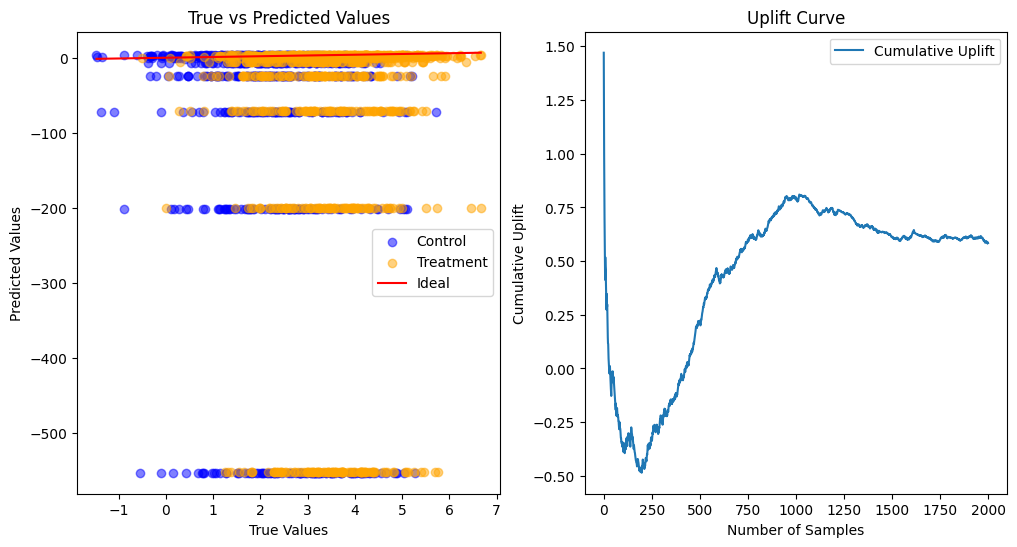

In [222]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Generate the dataset as previously described
n = 10_000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({
    'X1': X1,
    'X2': X2,
    'T': T,
    'time': time,
    'Y': Y
})

# Check for NaNs in the data
print("Number of NaNs in the dataset:", df_large.isnull().sum().sum())

# Prepare the data for training
X = df_large[['time', 'X1', 'X2', 'T']].values
y = df_large['Y'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train[:, 1:3] = scaler.fit_transform(X_train[:, 1:3])
X_test[:, 1:3] = scaler.transform(X_test[:, 1:3])

# Define Transformer block
def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

# Define the encoder
input0 = Input(shape=(1,), name='time')
input1 = Input(shape=(1,), name='treatment')
input2 = Input(shape=(2,), name='features')

# Concatenate inputs for the transformer block
concat_inputs = Concatenate()([input0, input1, input2])
concat_inputs = tf.expand_dims(concat_inputs, axis=1)

# Apply transformer block
transformer_output = transformer_block(concat_inputs, num_heads=2, ff_dim=32)
context = tf.squeeze(transformer_output, axis=1)

# Define the decoder
time_exp = Lambda(lambda x: tf.exp(x))(input0)
treatment_exp = Lambda(lambda x: tf.exp(x))(input1)

# Concatenate context with the exponential of time and treatment
decoder_input = Concatenate()([context, time_exp, treatment_exp])

# Output layers for mean and log variance
mean = Dense(1)(decoder_input)
log_variance = Dense(1)(decoder_input)

# Concatenate mean and variance to create a distribution
output = Concatenate()([mean, log_variance])

# Create the model
model = Model(inputs=[input0, input1, input2], outputs=output)

# # Define the negative log-likelihood loss function
# def nll(y_true, y_pred):
#     mean = y_pred[:, 0]
#     log_variance = y_pred[:, 1]
#     variance = tf.exp(log_variance)
#     return 0.5 * tf.reduce_mean(tf.math.log(2 * np.pi * variance) + tf.square(y_true - mean) / variance)

# Compile the model
model.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
history = model.fit(
    [X_train[:, 0], X_train[:, 3], X_train[:, 1:3]], 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the model
loss = model.evaluate([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])
pred_mean = y_pred[:, 0]

# Separate treatment and control predictions
control_indices = X_test[:, 3] == 0
treatment_indices = X_test[:, 3] == 1

y_test_control = y_test[control_indices]
pred_mean_control = pred_mean[control_indices]

y_test_treatment = y_test[treatment_indices]
pred_mean_treatment = pred_mean[treatment_indices]

# Plot true vs predicted values for control and treatment groups
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_control, pred_mean_control, alpha=0.5, label='Control', color='blue')
plt.scatter(y_test_treatment, pred_mean_treatment, alpha=0.5, label='Treatment', color='orange')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
plt.legend()

# Calculate the uplift score
uplift_score = pred_mean - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score)[::-1]
y_test_sorted = y_test[sorted_indices]
T_test_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift = np.cumsum((T_test_sorted - (1 - T_test_sorted)) * y_test_sorted)
cumulative_uplift /= np.arange(1, len(cumulative_uplift) + 1)

# Plot the uplift curve
plt.subplot(1, 2, 2)
plt.plot(cumulative_uplift, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()

# Calculate AUUC
auuc = np.trapz(cumulative_uplift)
print(f'AUUC: {auuc}')

plt.show()


Epoch 1/10


2024-06-01 17:16:36.692847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


127/128 [============================>.] - ETA: 0s - loss: 481427.8438

2024-06-01 17:16:39.023078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 3s 15ms/step - loss: 479648.7500 - val_loss: 279807.4375
Epoch 2/10
128/128 [==============================] - 2s 15ms/step - loss: 173368.2188 - val_loss: 90819.7031
Epoch 3/10
128/128 [==============================] - 2s 12ms/step - loss: 52034.6055 - val_loss: 24300.7031
Epoch 4/10
128/128 [==============================] - 2s 13ms/step - loss: 12844.4756 - val_loss: 5291.6260
Epoch 5/10
128/128 [==============================] - 1s 11ms/step - loss: 2597.4927 - val_loss: 933.3741
Epoch 6/10
128/128 [==============================] - 2s 13ms/step - loss: 432.4287 - val_loss: 142.6912
Epoch 7/10
128/128 [==============================] - 1s 11ms/step - loss: 69.0322 - val_loss: 28.0658
Epoch 8/10
128/128 [==============================] - 1s 11ms/step - loss: 18.9366 - val_loss: 12.3693
Epoch 9/10
128/128 [==============================] - 1s 12ms/step - loss: 11.6197 - val_loss: 10.2338
Epoch 10/10
128/128 [==============================] 

2024-06-01 17:16:53.607841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test loss: 9.237862586975098


2024-06-01 17:16:57.802674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 3s 5ms/step
AUUC: -191.19480873589578


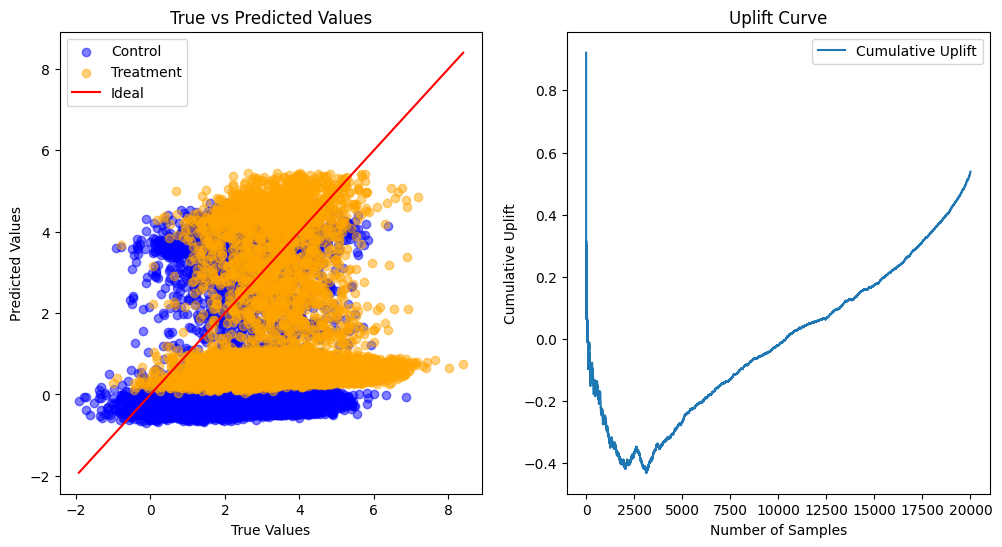

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, LayerNormalization, Dropout, MultiHeadAttention, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Data generation
np.random.seed(42)
tf.random.set_seed(42)
n = 100_000
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
T = np.random.binomial(1, p=1 / (1 + np.exp(-0.5 * X1 + 0.25 * X2)))
time = np.random.randint(0, 10, n)
initial_effect = 2
decay_rate = 0.3
stabilization_time = 5
treatment_effect = initial_effect * np.exp(-decay_rate * time)
treatment_effect[time > stabilization_time] = initial_effect * np.exp(-decay_rate * stabilization_time)
Y = 2 + treatment_effect * T + 0.5 * X1 - 0.25 * X2 + 0.1 * time + np.random.normal(0, 1, n)

df_large = pd.DataFrame({'X1': X1, 'X2': X2, 'T': T, 'time': time, 'Y': Y})

# Data preparation
X = df_large[['time', 'X1', 'X2', 'T']].values
y = df_large['Y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train[:, 1:3] = scaler.fit_transform(X_train[:, 1:3])
X_test[:, 1:3] = scaler.transform(X_test[:, 1:3])

# Transformer block
def transformer_block(inputs, num_heads, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([inputs, attn_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ff_output]))

# Model definition
input0 = Input(shape=(1,), name='time')
input1 = Input(shape=(1,), name='treatment')
input2 = Input(shape=(2,), name='features')
concat_inputs = Concatenate()([input0, input1, input2])
concat_inputs = tf.expand_dims(concat_inputs, axis=1)
transformer_output = transformer_block(concat_inputs, num_heads=2, ff_dim=32)
context = tf.squeeze(transformer_output, axis=1)
time_exp = Lambda(lambda x: tf.exp(x))(input0)
treatment_exp = Lambda(lambda x: tf.exp(x))(input1)
decoder_input = Concatenate()([context, time_exp, treatment_exp])
mean = Dense(1)(decoder_input)
log_variance = Dense(1)(decoder_input)
output = Concatenate()([mean, log_variance])
model = Model(inputs=[input0, input1, input2], outputs=output)

# Loss function
def nll(y_true, y_pred):
    mean = y_pred[:, 0]
    log_variance = y_pred[:, 1]
    variance = tf.exp(log_variance)
    return 0.5 * tf.reduce_mean(tf.math.log(2 * np.pi * variance) + tf.square(y_true - mean) / variance)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
# Train the model
history = model.fit(
    [X_train[:, 0], X_train[:, 3], X_train[:, 1:3]], 
    y_train, 
    epochs=10, 
    batch_size=500, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

# Evaluate the model
loss = model.evaluate([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]], y_test, verbose=0)
print(f'Test loss: {loss}')

# Make predictions
y_pred = model.predict([X_test[:, 0], X_test[:, 3], X_test[:, 1:3]])
pred_mean = y_pred[:, 0]
# Separate treatment and control predictions
control_indices = X_test[:, 3] == 0
treatment_indices = X_test[:, 3] == 1
y_test_control = y_test[control_indices]
pred_mean_control = pred_mean[control_indices]
y_test_treatment = y_test[treatment_indices]
pred_mean_treatment = pred_mean[treatment_indices]

# Plot true vs predicted values for control and treatment groups
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test_control, pred_mean_control, alpha=0.5, label='Control', color='blue')
plt.scatter(y_test_treatment, pred_mean_treatment, alpha=0.5, label='Treatment', color='orange')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', label='Ideal')
plt.legend()

# Calculate the uplift score
uplift_score = pred_mean - y_test

# Sort the data based on the uplift score
sorted_indices = np.argsort(uplift_score)[::-1]
y_test_sorted = y_test[sorted_indices]
T_test_sorted = X_test[sorted_indices][:, 3]

# Calculate cumulative uplift
cumulative_uplift = np.cumsum((T_test_sorted - (1 - T_test_sorted)) * y_test_sorted)
cumulative_uplift /= np.arange(1, len(cumulative_uplift) + 1)

# Plot the uplift curve
plt.subplot(1, 2, 2)
plt.plot(cumulative_uplift, label='Cumulative Uplift')
plt.xlabel('Number of Samples')
plt.ylabel('Cumulative Uplift')
plt.title('Uplift Curve')
plt.legend()

# Calculate AUUC
auuc = np.trapz(cumulative_uplift)
print(f'AUUC: {auuc}')

plt.show()

